In [176]:
import os
import time
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.ndimage.measurements import label
from skimage.feature import hog
import matplotlib
import imageio
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
from IPython.display import HTML
import collections

%matplotlib inline
%load_ext line_profiler
matplotlib.rcParams['figure.figsize'] = (10.0, 12.0)
imageio.plugins.ffmpeg.download()


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Reading 17760 images
******************Done extracting features. Time: 102.84933567047119
13320 training images and 6156 features
Fit in 14.18 s
Test acc 0.989


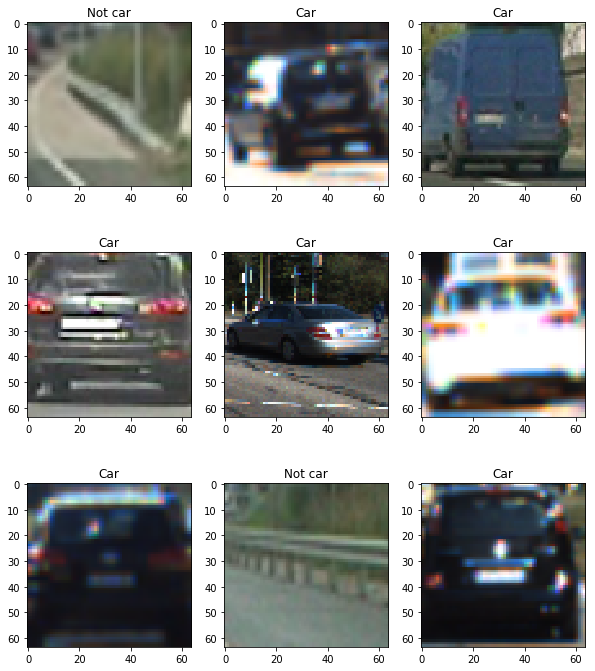

In [46]:
classifier_orig, scaler_orig = train_car_classifier('./data/vehicles/', 
                                          './data/non-vehicles/',
                                          show=True)

Reading 17760 images
******************Done extracting features. Time: 15.398346185684204
X
X_scaler
X_scaled
Train test split
Grid searching
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=10 ............................................................
[CV] C=10 ............................................................
[CV] .................. C=0.1, score=0.9782857142857143, total= 3.5min
[CV] C=10 ............................................................


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  5.6min


[CV] .................... C=1, score=0.9782857142857143, total= 3.5min
[CV] C=100 ...........................................................
[CV] .................. C=0.1, score=0.9744886233049873, total= 3.6min
[CV] C=100 ...........................................................


[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed:  5.8min remaining: 17.3min


[CV] .................... C=1, score=0.9744886233049873, total= 3.6min
[CV] C=100 ...........................................................
[CV] .................. C=0.1, score=0.9809676679660628, total= 3.7min


[Parallel(n_jobs=8)]: Done   5 out of  12 | elapsed:  5.9min remaining:  8.3min


[CV] ................... C=10, score=0.9744886233049873, total= 3.6min
[CV] .................... C=1, score=0.9809676679660628, total= 3.7min


[Parallel(n_jobs=8)]: Done   7 out of  12 | elapsed:  6.0min remaining:  4.3min


[CV] ................... C=10, score=0.9809676679660628, total= 3.7min
[CV] ................... C=10, score=0.9782857142857143, total= 2.1min


[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:  8.9min remaining:  3.0min


[CV] .................. C=100, score=0.9782857142857143, total= 2.0min
[CV] .................. C=100, score=0.9744886233049873, total= 2.1min
[CV] .................. C=100, score=0.9809676679660628, total= 2.2min


[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:  9.2min finished


13320 training images and 6884 features
Fit in 697.07 s
Test acc 0.980


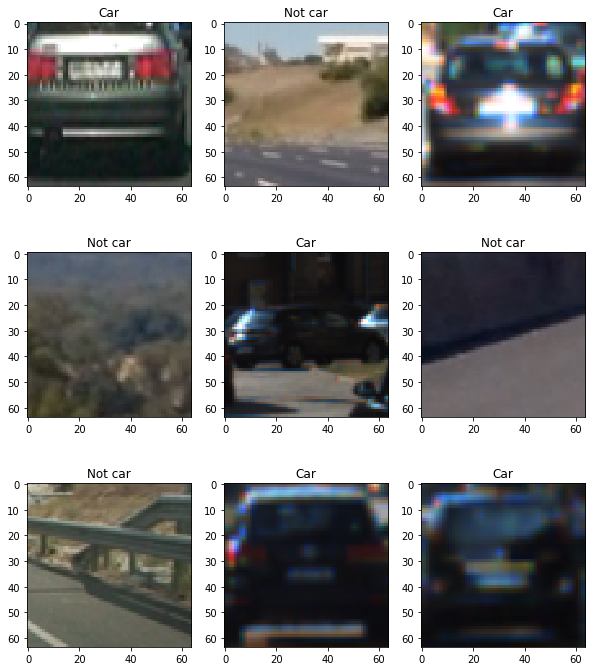

In [65]:
classifier, scaler = train_car_classifier_opencv('./data/vehicles/',
                                                 './data/non-vehicles/',
                                                 show=True,
                                                 grid_search=True)

In [69]:
classifier.best_params_

{'C': 0.1}

Reading 17760 images
******************Done extracting features. Time: 16.03930163383484
X
X_scaler
X_scaled
Train test split
Not grid searching
Fitting
Fit
13320 training images and 6884 features
Fit in 18.28 s
Test acc 0.983


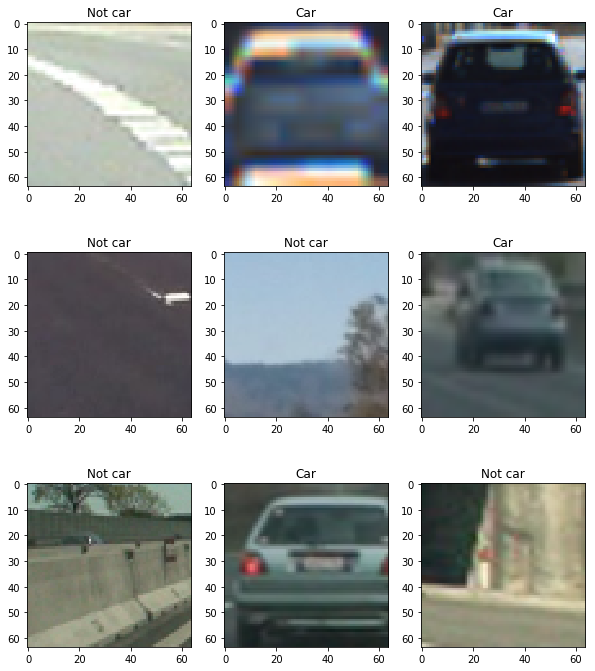

In [71]:
classifier_4, scaler_4 = train_car_classifier_opencv('./data/vehicles/',
                                                 './data/non-vehicles/',
                                                 show=True,
                                                 grid_search=False)

In [175]:
classifier.best_score_

0.99537828553294161

## Classifier
* Linear SVC classifier used
* HSV color space used
* Spatial binning of color used with a size of 16x16
* Histogram of colors used with 32 bins
* Histogram of gradients used
    * 8 pixels per cell and 2 cells per block
    * Number of orientation bins set to 9 based on this [paper](https://courses.engr.illinois.edu/ece420/fa2017/hog_for_human_detection.pdf) which showed statistically significant increases in performance up to 9 bins.

In [70]:
#------------------80-chars----------------------------------------------------|
def train_car_classifier_opencv(veh_path, nonveh_path, grid_search=False, show=False):
    """
    Trains a classifier to recognize cars
    
    :param veh_path: Directory where vehicles images are found
    :param nonveh_path: Directory where non-vehicle images are found
    :param show: Whether to display information about progress and tests set
    :return classifier: A classifier that detects cars
    :return X_scaler: Scaler used to remove mean and scaling of features
    """
    veh_files = retrieve_files(veh_path, 'png')
    nonveh_files = retrieve_files(nonveh_path, 'png')
    img_files = np.hstack((veh_files, nonveh_files))
    labels = np.hstack((np.ones(veh_files.shape[0]), 
                        np.zeros(nonveh_files.shape[0])))
    features = []
    if show:
        print('Reading {0} images'.format(len(img_files)))
    t_i = time.time()
    hog_descr = get_hog_descriptor()
    for count, img_file in enumerate(img_files):
        if count % 1000 == 0:
            if show:
                print('*', end='')
        img = mpimg.imread(img_file)
        if img.dtype == np.dtype(np.float32):
            img = np.uint8(img*255)
        features.append(get_classifier_features_opencv(img, hog_descr, 
                                                       color_space='YUV', 
                                                       hist_bool=True,
                                                       hist_channel=0,
                                                       spatial_channel=3,
                                                       hog_channel=3))
    t_f = time.time()
    if show:
        print('Done extracting features. Time: {}'.format(t_f - t_i))
    X = np.asarray(features)
    print('X')
    X_scaler = StandardScaler().fit(X)
    print('X_scaler')
    X_scaled = X_scaler.transform(X)
    print('X_scaled')
    X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(
        X_scaled, labels, img_files)
    print('Train test split')
    t_i = time.time()
    if grid_search:
        print('Grid searching')
        parameters = {'C':[0.1, 1, 10, 100]} 
        svr = SVC(kernel='linear')
        classifier = GridSearchCV(svr, parameters, scoring='f1', n_jobs=8, verbose=10)
        classifier.fit(X_train, y_train)
        t_f = time.time()
    else:
        print('Not grid searching')
        classifier = LinearSVC(C=0.1)
        print('Fitting')
        classifier.fit(X_train, y_train)
        print('Fit')
    t_f = time.time()
    if show:
        print('{0} training images and {1} features'.format(X_train.shape[0],
                                                            X_train.shape[1]))
        print('Fit in {0:.2f} s'.format(t_f - t_i))
        print('Test acc {0:.3f}'.format(classifier.score(X_test, y_test)))
        for i in range(1, 10):
            test_img = mpimg.imread(img_test[i])
            ax = plt.subplot(3,3,i)
            prediction = classifier.predict(X_test[i].reshape(1, -1))
            if prediction == 1:
                ax.set_title('Car')
            else:
                ax.set_title('Not car')
            ax.imshow(test_img)
        plt.show()
    return classifier, X_scaler

In [3]:
#------------------80-chars----------------------------------------------------|
def retrieve_files(file_folder, file_format):
    """
    Returns an array of all image *files* in a folder with a specified format
    
    :param file_folder: Folder to find images as a string
    :param file_format: File format of the image as a string
    """
    if file_format[0] != '.':
        file_format = '.' + file_format
    image_files = glob.glob(file_folder + '/*/*' + file_format)
    return np.array([file for file in image_files])

In [57]:
#------------------80-chars----------------------------------------------------|
def get_classifier_features_opencv(img, hog_descriptor, hist_bool=True, spatial_bool=True,
                                   hog_bool=True, color_space='RGB', hist_channel=3,
                                   hist_bins=32, spatial_channel=3, hog_channel=3):
    """
    Combine different feature vectors together for each image
    
    :param img: Image to extract features from
    :param hist_bool: Whether or not to include histogram of color features
    :param spatial_bool: Whether or not to include spatial color features
    :param hog_bool: Whether or not to include histogram of gradient features
    :param color_space: Color space to convert features to before extracting
    :param hog_channel: Channel to include in HOG features. 0-1st, 3-all
    :param pix_per_cell: Pixels per hog cell
    :param cells_per_block: Cells ber hog block
    :param orient: Direction bins in histogram for HOG
    :return features: HOG feature vector
    """
    features = []
    height, width, _ = img.shape
    hist_feat = []
    spatial_feat = []
    hog_feat = []
    img = convert_color(img, cspace=color_space)
    #TODO: Loop over image
    if hist_bool:
        hist_feat = color_hist(img, hist_channel, hist_bins)
    if spatial_bool:
        spatial_feat = bin_spatial(img, channel=spatial_channel)
    if hog_bool:
        if hog_channel == 3:
            hog_feat = get_hog_opencv(img, hog_descriptor).squeeze()
        else:
            hog_feat = get_hog_opencv(img[:,:,hog_channel], hog_descriptor).squeeze()
#     print(hist_feat.shape, spatial_feat.shape, hog_feat.shape)
    features = np.hstack((hist_feat, spatial_feat, hog_feat))
    return features

In [6]:
def convert_color(img, cspace='RGB'):
    """
    Converts an RGB image to the given color space
    Available - RGB, BGR, HSV, HLS, YUV, YCC, LUV, LAB
    
    :param img: Image to convert
    :param cspace: Colorspace to convert image to
    """
    
    if cspace == 'RGB':
        return img
    if cspace == 'BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if cspace == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if cspace == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if cspace == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if cspace == 'YCC':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    if cspace == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if cspace == 'LAB':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

In [7]:
def bin_spatial(img, channel=3, size=(16,16)):
    """
    Create feature to represent position of color in space
    
    :param img: Image to extract feature from
    :param size: Size at which to extract features
    """
    spatial_feat = []
    if channel == 0 or channel == 3:
        spatial_feat.append(cv2.resize(img[:,:,0], size).ravel())
    if channel == 1 or channel == 3:
        spatial_feat.append(cv2.resize(img[:,:,1], size).ravel())
    if channel == 2 or channel == 3:
        spatial_feat.append(cv2.resize(img[:,:,2], size).ravel())
    return np.hstack(spatial_feat)

In [8]:
#------------------80-chars----------------------------------------------------|
def color_hist(img, channel=3, n_bins=32):
    """
    Create feature vector of an images distribution of colors with histograms
    
    :param img: Image to extract color features from
    :param n_bins: Number of bins to sort pixel intensities into
    """
    hist_feat = []
    if channel == 0 or channel == 3:
        hist_feat.append(np.histogram(img[:,:,0], bins=n_bins)[0])
    if channel == 1 or channel == 3:
        hist_feat.append(np.histogram(img[:,:,1], bins=n_bins)[0])
    if channel == 2 or channel == 3:
        hist_feat.append(np.histogram(img[:,:,2], bins=n_bins)[0])
    return np.hstack(hist_feat)

In [23]:
def get_hog_descriptor(pix_per_win=64, pix_per_block=16, pix_per_step=4, 
                   pix_per_cell=8, n_bins=9):
    """
    Creates a HOG descriptor """
    if not isinstance(pix_per_win, int) or \
        not isinstance(pix_per_block, int) or \
        not isinstance(pix_per_step, int) or \
        not isinstance(pix_per_cell, int) or \
        not isinstance(n_bins, int):
            raise TypeError('HOG Descriptor inputs must be integers. OpenCV error unhelpful')
    return cv2.HOGDescriptor((pix_per_win, pix_per_win),
                             (pix_per_block, pix_per_block),
                             (pix_per_step, pix_per_step),
                             (pix_per_cell, pix_per_cell),
                             n_bins)
    

In [24]:
#------------------80-chars----------------------------------------------------|
def get_hog_opencv(img, hog_descriptor):
    """
    Compute HOG feature vector on image with given HOG descriptor
    
    :param img: Image to compute HOG features on
    :param hog_descriptor: Describes HOG window, block, stride, cell size & bins
    """
    return hog_descriptor.compute(img)

In [165]:
#------------------80-chars----------------------------------------------------|
def pipeline_opencv(img, show=False):
    """
    Pipeline detects vehicles in an image
    Uses global classifier to prevent passing large data a lot
    
    :param img: Image to detect cars in
    :return final_img: Image with bounding boxes around cars
    """
    
    hog_descr = get_hog_descriptor()
    boxes = []
    small_boxes = detect_cars_opencv(img, classifier=classifier_4, X_scaler=scaler_4, hog_descriptor=hog_descr, 
                                     scale=0.8, overlap=0.2, show=show, y_bounds=(0.45, 0.7))#, x_bounds=(0.3, 0.9))
    if small_boxes.size > 0:
        boxes.append(small_boxes)
    med_boxes = detect_cars_opencv(img, classifier=classifier_4, X_scaler=scaler_4, hog_descriptor=hog_descr, 
                                   scale=0.6, overlap=0.2, show=show, y_bounds=(0.5, 0.9))
    if med_boxes.size > 0:
        boxes.append(med_boxes)
    large_boxes = detect_cars_opencv(img, classifier=classifier_4, X_scaler=scaler_4, hog_descriptor=hog_descr,
                                     scale=0.4, overlap=0.2, show=show, y_bounds=(0.5, 1.0))
    if large_boxes.size > 0:
        boxes.append(large_boxes)
    boxes = np.vstack(boxes)
    if show:
        print(boxes)
        box_img = np.copy(img)
        for bounding_box in boxes:
            cv2.rectangle(box_img, (bounding_box[2], bounding_box[0]),
                                   (bounding_box[3], bounding_box[1]),
                                   (255, 0, 0), 6)
        plt.imshow(box_img)
        plt.show()
    detection_heatmap = add_heat(img, boxes, show=show)
    detection_heatmap = apply_threshold(detection_heatmap, 3)
    labels = label_cars(detection_heatmap, show=show)
    final_img = draw_labeled_boxes(img, labels, show=show)
    return final_img

In [191]:
#------------------80-chars----------------------------------------------------|
def get_bounding_boxes(img, show=False):
    """
    Extract bounding boxes from current frame
    
    :param img: Image to detect cars in
    :return boxes: 4xn nd array of boxes [y_start, y_end, x_start, x_end]
    """
    
    hog_descr = get_hog_descriptor()
    boxes = []
    small_boxes = detect_cars_opencv(img, classifier=classifier_4, X_scaler=scaler_4, hog_descriptor=hog_descr, 
                                     scale=0.8, overlap=0.2, show=show, y_bounds=(0.5, 0.7))#, x_bounds=(0.3, 0.9))
    if small_boxes.size > 0:
        boxes.append(small_boxes)
    med_boxes = detect_cars_opencv(img, classifier=classifier_4, X_scaler=scaler_4, hog_descriptor=hog_descr, 
                                   scale=0.6, overlap=0.2, show=show, y_bounds=(0.5, 0.9))
    if med_boxes.size > 0:
        boxes.append(med_boxes)
    large_boxes = detect_cars_opencv(img, classifier=classifier_4, X_scaler=scaler_4, hog_descriptor=hog_descr,
                                     scale=0.4, overlap=0.2, show=show, y_bounds=(0.5, 1.0))
    if large_boxes.size > 0:
        boxes.append(large_boxes)
    
    return np.vstack(boxes)

In [174]:
#------------------80-chars----------------------------------------------------|
def detect_cars_opencv(img, classifier, X_scaler, hog_descriptor, scale=1.0,
                       overlap=1.0, show=False, y_bounds=(0.0, 1.0), 
                       x_bounds=(0.0, 1.0)):
    """
    Function tries to detect cars using sliding windows and then returns a list
    of bounding boxes where cars could be.
    
    :param img: Image to detect cars within
    :param classifier: Classifier that determines if a window is a car or not
    :param X_scaler: Scaler used to remove mean and scaling of features
    :param scale: Amount to scale image to get multiple size boxes
    :return bounding_boxes: ndarray of windows where cars detected
    """
    
    window_size = 64
    img = convert_color(img, cspace='YUV')
    if scale != 1.0:
        img = cv2.resize(img, (np.int(img.shape[1]*scale), np.int(img.shape[0]*scale)))
    height = img.shape[0]
    width = img.shape[1]
    bounding_boxes=[]
    step = max(1,int(window_size*overlap))
    count = 0
    y_start = int(y_bounds[0]*height)
    y_end   = int(y_bounds[1]*height) - window_size - 1
    x_start = int(x_bounds[0]*width)
    x_end   = int(x_bounds[1]*width) - window_size - 1
    for y in range(y_start , y_end, step):
        for x in range(x_start, x_end, step):
            features = []
            count += 1
            pix_window = img[y:y + window_size, x:x + window_size]
            hist_feat = color_hist(pix_window, channel=0)
            features.append(hist_feat)
            spatial_feat = bin_spatial(pix_window)
            features.append(spatial_feat)
            hog_feat = get_hog_opencv(pix_window, hog_descriptor).squeeze()
            features.append(hog_feat)
            features = np.hstack(features).reshape(1,-1)
            scaled_features = X_scaler.transform(features)
            if classifier.predict(scaled_features) == 1:
                bounding_box = [int(y/scale), int((y + window_size)/scale), 
                                int(x/scale), int((x + window_size)/scale)]
                bounding_boxes.append(bounding_box)
#                 cv2.rectangle(img, (x, y), (x + window_size, y + window_size), (255,0,255), 6)
#                 if show:
#                     plt.imshow(pix_window)
#                     plt.show()
#             if count % 8 == 1 and show:
#                 cv2.rectangle(img, (x, y), (x + window_size, y + window_size), (255,0,255), 6)
#                 print(x, width - window_size - 1, step)
#                 print(hist_feat.shape, spatial_feat.shape, hog_feat.shape)
#     if show:
#         img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
#         plt.imshow(img)
#         plt.show()
#         print('Searched {} windows'.format(count))
#         print('Found {} boxes'.format(len(bounding_boxes)))
    return np.asarray(bounding_boxes)

In [153]:
def add_heat(img, bounding_boxes, show=False):
    heatmap = np.zeros(img.shape[:2])
    for box in bounding_boxes:
        heatmap[box[0]:box[1], box[2]:box[3]] += 1
    if show:
        plt.imshow(heatmap)
        plt.show()
    return heatmap

In [156]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap < threshold] = 0
    return heatmap

In [17]:
def label_cars(heatmap, show=False):
    labels = label(heatmap)
    if show:
        print('{0} cars found'.format(labels[1]))
        plt.imshow(labels[0], cmap='gray')
        plt.show()
    return labels

In [18]:
def draw_labeled_boxes(img, labels, show=False):
    for car_num in range(1,labels[1]+1):
        nonzero = (labels[0] == car_num).nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        bounding_box = ((np.min(nonzero_x), np.min(nonzero_y)),
                        (np.max(nonzero_x), np.max(nonzero_y)))
        cv2.rectangle(img, bounding_box[0], bounding_box[1], (0,0,255), 6)
    if show:
        plt.imshow(img)
        plt.show()
    return img

In [36]:
hog_descr = get_hog_descriptor()

In [177]:
%lprun -f detect_cars_opencv detect_cars_opencv(img, classifier=classifier_4, X_scaler=scaler_4, hog_descriptor=hog_descr, scale=0.6, overlap=0.6)

In [179]:
%lprun -f pipeline_opencv pipeline_opencv(img)

In [37]:
%lprun -f detect_cars()

In [189]:
boxes = get_bounding_boxes(img)
cur_heatmap = add_heat(img, boxes)

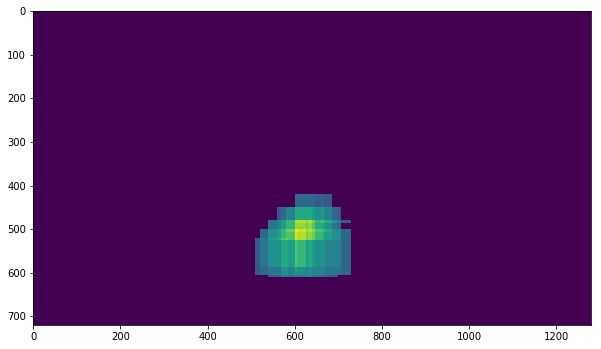

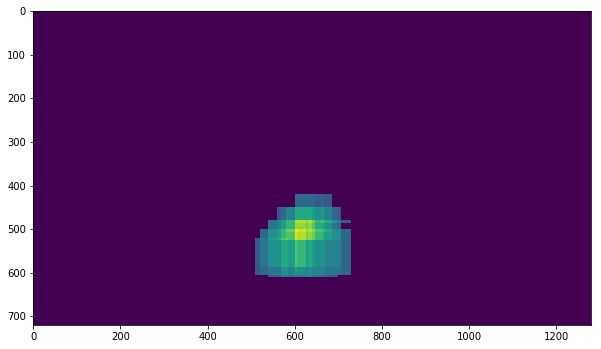

In [210]:
a = deque(maxlen=10)
a.append(cur_heatmap)
a.append(cur_heatmap)
a.append(cur_heatmap)
mean_heat = np.mean(a, axis=0)
thresh = apply_threshold(mean_heat, 5)
plt.imshow(mean_heat)
plt.show()
plt.imshow(thresh)
plt.show()

In [222]:
class VehicleDetector:
    def __init__(self):
        self.heatmaps = collections.deque(maxlen=10)
    def process(self, img, show=False):
        boxes = get_bounding_boxes(img)
        cur_heatmap = add_heat(img, boxes, show=show)
        self.heatmaps.append(cur_heatmap)
        mean_heat = cur_heatmap + np.mean(self.heatmaps, axis=0)
        thresh_heatmap = apply_threshold(mean_heat, 8)
        labels = label_cars(thresh_heatmap, show=show)
        final_img = draw_labeled_boxes(img, labels, show=show)
        return final_img

[[440 546 560 666]
 [460 566 560 666]
 [450 610 540 699]]


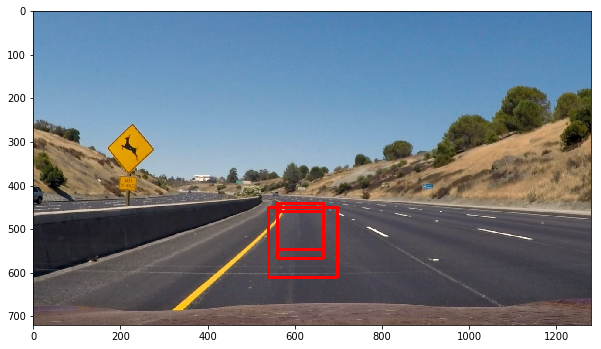

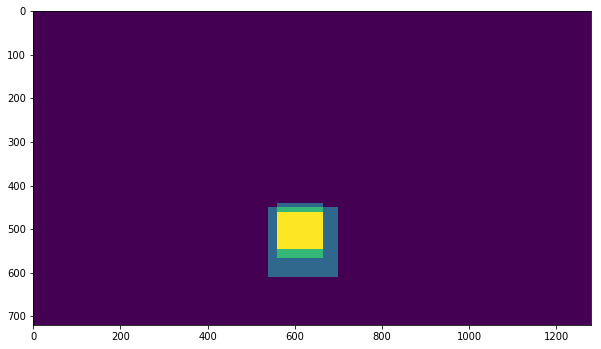

1 cars found


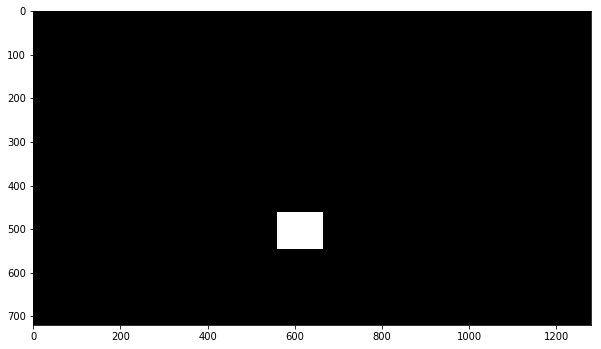

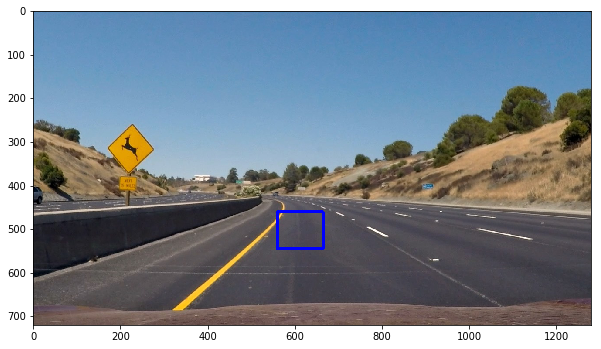

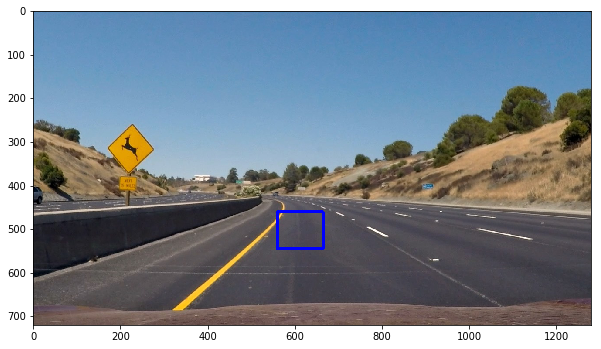

In [171]:
img = mpimg.imread('./test_images/test2.jpg')
img = pipeline_opencv(img, show=True)
plt.imshow(img)
plt.show()

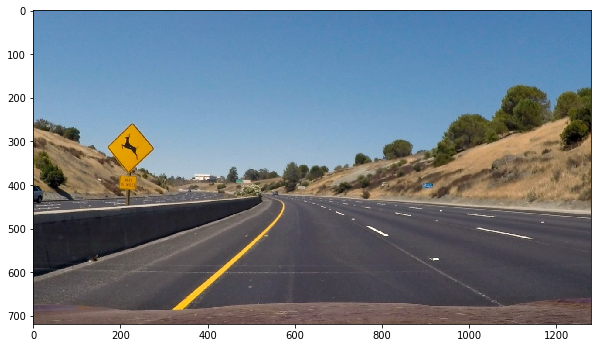

In [88]:
img = mpimg.imread('./test_images/test2.jpg')
img = pipeline_opencv(img, show=False)
plt.imshow(img)
plt.show()

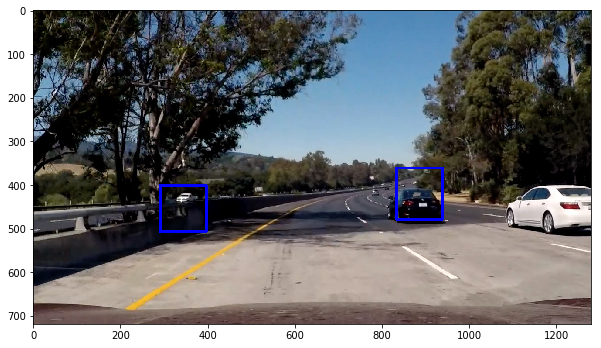

In [98]:
img = mpimg.imread('./test_images/test5.jpg')
img = pipeline_opencv(img, show=False)
plt.imshow(img)
plt.show()

In [ ]:
time_str = np.datetime_as_string(np.datetime64('now'))
challenge_output = 'test_vid_{}.mp4'.format(time_str)

# txt_clip = TextClip("Advanced Lanelines\nChris Sketch",font='Arial',fontsize=40,color='white')
# txt_clip = txt_clip.set_pos(('center', 'top')).set_duration(8)
detector = VehicleDetector()
clip1 = VideoFileClip('./test_video.mp4')
challenge_clip = clip1.fl_image(detector.process) #NOTE: this function expects color images!!

video = CompositeVideoClip([challenge_clip])
%time video.write_videofile(challenge_output, audio=False, verbose=False)

In [ ]:
time_str = np.datetime_as_string(np.datetime64('now'))
challenge_output = 'proj_vid_{}.mp4'.format(time_str)

# txt_clip = TextClip("Advanced Lanelines\nChris Sketch",font='Arial',fontsize=40,color='white')
# txt_clip = txt_clip.set_pos(('center', 'top')).set_duration(8)
detector = VehicleDetector()
clip1 = VideoFileClip('./project_video.mp4')
challenge_clip = clip1.fl_image(detector.process) #NOTE: this function expects color images!!

video = CompositeVideoClip([challenge_clip])
%time video.write_videofile(challenge_output, audio=False, verbose=False)

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')
img = crop_image(img)
small_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, scale=0.8, overlap=0.5)
med_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, scale=0.6, overlap=0.6)
large_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, scale=0.4)
boxes = np.concatenate((small_boxes, med_boxes, large_boxes))
new_img = np.copy(img)
for bounding_box in boxes:
    cv2.rectangle(img, (bounding_box[2], bounding_box[0]),
                       (bounding_box[3], bounding_box[1]),
                       (255, 0, 0), 6)

plt.imshow(img)
plt.show()
my_heat = add_heat(img, boxes)
my_heat = apply_threshold(my_heat, 2)
labels = label_cars(my_heat, show=True)
draw_labeled_boxes(new_img, labels, show=True)

In [19]:
#------------------80-chars----------------------------------------------------|
def load_images(file_folder, file_format):
    """
    Returns an array of all images in a folder with a specified format
    
    :param file_folder: Folder to find images as a string
    :param file_format: File format of the image as a string
    """
    if file_format[0] != '.':
        file_format = '.' + file_format
    image_files = glob.glob(file_folder + '/*/*' + file_format)
    return np.array([mpimg.imread(file) for file in image_files])

In [20]:
def split_image(img, y_split):
    """
    Splits image in half top-bottom
    
    :param img: Image to split in half
    :param y_split: Decimal fraction to split image in half
    :return top: Top half of image
    :return bottom: Bottom half of image
    """
    height = img.shape[0]
    split_point = np.int(height*y_split)
    top = img[0:split_point]
    bottom = img[split_point:height-1]
    return top, bottom

In [21]:
#------------------80-chars----------------------------------------------------|
def crop_image(img, x_usable=(0.0,1.0), y_usable=(0.5,1.0)):
    """
    Crop parts of the image where cars should not exist
    
    :param img: Image to be cropped
    :param x_usable: Tuple - Fraction of image 0-1 in x start-end that's usable
    :param y_usable: Tuple - Fraction of image 0-1 in y start-end that's usable
    """
    x_start = np.int(img.shape[1]*x_usable[0])
    x_end   = np.int(img.shape[1]*x_usable[1])
    y_start = np.int(img.shape[0]*y_usable[0])
    y_end   = np.int(img.shape[0]*y_usable[1])
    return img[y_start:y_end,x_start:x_end,:]